本节代码是分别使用Python实现逆滤波和维纳滤波的代码

# 逆滤波
## 原理回顾
逆滤波基于图像退化模型，在已知退化函数 `h(x,y)` 且无噪声或噪声可忽略的情况下，通过逆运算恢复原始图像，在频域中的表达式为 $$F(u,v) = G(u,v) / H(u,v)$$
也就是对退化后的图像频谱 `G(u,v)` 除以退化函数的频谱 `H(u,v)` 来尝试获取原始图像的频谱 `F(u,v)`，再通过逆变换回到空间域得到原始图像。但实际中完全无噪声很难做到，噪声可能会导致恢复结果出现较大偏差甚至无法正常恢复。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def inverse_filtering(image_degraded, h):
    """
    对退化图像进行逆滤波
    :param image_degraded: 退化后的图像（以灰度图形式，numpy数组表示）
    :param h: 退化函数（在频域中的表示，numpy数组形式）
    :return: 逆滤波恢复后的图像（numpy数组表示）
    """
    # 获取图像的高度和宽度
    height, width = image_degraded.shape[:2]

    # 对退化图像进行快速傅里叶变换，并将零频率分量移到频谱中心
    G = np.fft.fft2(image_degraded)
    G_shift = np.fft.fftshift(G)

    # 对退化函数进行同样的操作（确保尺寸等匹配）
    H = np.fft.fft2(h, s=(height, width))
    H_shift = np.fft.fftshift(H)

    # 进行逆滤波操作（频域），添加一个小的常数防止除数为0
    F_shift = G_shift / (H_shift + 1e-8)

    # 将零频率分量移回原来的位置
    F = np.fft.ifftshift(F_shift)

    # 进行逆快速傅里叶变换，转换回空间域
    image_restored = np.fft.ifft2(F)
    image_restored = np.abs(image_restored).astype(np.uint8)
    return image_restored

### 代码解释
- **`inverse_filtering`函数**：
    - 该函数接受两个参数，`image_degraded` 是输入的退化后的灰度图像，以二维的 `numpy` 数组形式传入，`h` 是退化函数在频域中的表示（同样以 `numpy` 数组形式）。这里假设 `h` 的尺寸等是符合要求的，实际应用中要根据具体的退化模型和图像尺寸等进行准确设置和调整。
    - 在函数内部，首先通过 `image_degraded.shape[:2]` 获取图像的高度和宽度。然后对退化图像 `image_degraded` 进行快速傅里叶变换（`FFT`），使用 `np.fft.fft2` 函数得到频谱 `G`，再通过 `np.fft.fftshift` 函数将零频率分量移到频谱中心，得到 `G_shift`。
    - 接着对退化函数 `h` 也进行类似操作，先使用 `np.fft.fft2` 函数进行 `FFT`（通过传入 `s=(height, width)` 参数确保变换后的尺寸与图像频谱尺寸一致，便于后续运算），再用 `np.fft.fftshift` 函数将零频率分量移到频谱中心，得到 `H_shift`。
    - 进行逆滤波操作时，按照公式 `F_shift = G_shift / (H_shift + 1e-8)` 在频域中计算恢复图像的频谱 `F_shift`，这里添加 `1e-8` 这个小的常数是为了防止出现除数为 `0` 的情况（因为 `H_shift` 中可能存在元素为 `0` 的情况，尤其是在一些简单模拟或实际有零点的退化函数情况下）。
    - 之后使用 `np.fft.ifftshift` 函数将零频率分量移回原来的位置，得到 `F`，再使用 `np.fft.ifft2` 函数进行逆快速傅里叶变换，将图像从频域转换回空间域，得到 `image_restored`。最后取绝对值（因为逆变换后的结果可能包含虚部，而图像像素值是实数，只关注实部）并通过 `astype(np.uint8)` 将其转换为8位无符号整数类型（符合图像像素值的常见数据类型要求），返回恢复后的图像。

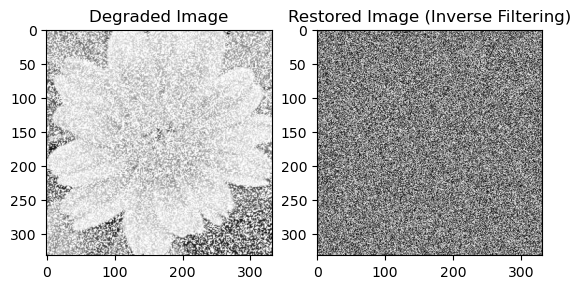

In [5]:
# 读取退化图像（以灰度图模式读取）
image_degraded = cv2.imread('degraded-flower.jpg', 0)

# 假设已知退化函数（这里简单模拟一个退化函数示例，实际应用中需根据具体退化情况确定）
h = np.ones((5, 5)) / 25
# 进行逆滤波
restored_image = inverse_filtering(image_degraded, h)

# 使用matplotlib在Jupyter Notebook中显示退化图像和恢复后的图像
plt.subplot(1, 2, 1)
plt.imshow(image_degraded, cmap='gray')
plt.title('Degraded Image')

plt.subplot(1, 2, 2)
plt.imshow(restored_image, cmap='gray')
plt.title('Restored Image (Inverse Filtering)')

plt.show()

可以看到，这个退化函数选取得不是很好，没有更好地还原出图像。

# 维纳滤波
## 原理回顾
维纳滤波是在最小均方误差下的最优滤波方法，其频域表达式为 $$W(u,v) = H*(u,v) / (|H(u,v)|² + Sₙ(u,v) / Sₑ(u,v))$$
其中 `H*(u,v)` 是 `H(u,v)` 的共轭，`Sₙ(u,v)` 和 `Sₑ(u,v)` 分别是噪声和原始图像的功率谱密度。通过构造这样的滤波器，在考虑噪声影响的情况下，尽可能使复原后的图像与原始图像的均方误差最小，以达到较好的图像恢复效果。

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def wiener_filtering(image_degraded, h, sn, sf):
    """
    对退化图像进行维纳滤波
    :param image_degraded: 退化后的图像（以灰度图形式，numpy数组表示）
    :param h: 退化函数（在频域中的表示，numpy数组形式）
    :param sn: 噪声的功率谱密度（numpy数组形式，与图像频谱尺寸匹配）
    :param sf: 原始图像的功率谱密度（numpy数组形式，与图像频谱尺寸匹配）
    :return: 维纳滤波恢复后的图像（numpy数组表示）
    """
    # 获取图像的高度和宽度
    height, width = image_degraded.shape[:2]

    # 对退化图像进行快速傅里叶变换，并将零频率分量移到频谱中心
    G = np.fft.fft2(image_degraded)
    G_shift = np.fft.fftshift(G)

    # 对退化函数进行同样的操作（确保尺寸等匹配）
    H = np.fft.fft2(h, s=(height, width))
    H_shift = np.fft.fftshift(H)
    H_conj = np.conj(H_shift)

    # 计算维纳滤波器的频域表达式
    W = H_conj / (np.abs(H_shift) ** 2 + sn / sf)

    # 应用维纳滤波器
    F_shift = G_shift * W

    # 将零频率分量移回原来的位置
    F = np.fft.ifftshift(F_shift)

    # 进行逆快速傅里叶变换，转换回空间域
    image_restored = np.fft.ifft2(F)
    image_restored = np.abs(image_restored).astype(np.uint8)
    return image_restored

### 代码解释
- **`wiener_filtering`函数**：
    - 该函数接受四个参数，`image_degraded` 是输入的退化后的灰度图像，`h` 是退化函数在频域中的表示，`sn` 是噪声的功率谱密度（以 `numpy` 数组形式且与图像频谱尺寸匹配），`sf` 是原始图像的功率谱密度（同样以 `numpy` 数组形式且与图像频谱尺寸匹配）。在实际应用中，准确获取 `sn` 和 `sf` 通常是比较复杂的，可能需要根据一些先验知识、统计特性或者其他估计方法来确定，这里只是简单模拟示例。
    - 在函数内部，首先获取图像的高度和宽度，然后对退化图像 `image_degraded` 进行与逆滤波中类似的操作，即先进行快速傅里叶变换（`FFT`）再将零频率分量移到频谱中心，得到 `G_shift`。对退化函数 `h` 也进行 `FFT`、`fftshift` 操作得到 `H_shift`，并通过 `np.conj` 函数获取其共轭 `H_conj`。
    - 接着按照维纳滤波的频域表达式 `W = H_conj / (np.abs(H_shift) ** 2 + sn / sf)` 计算维纳滤波器的频域表示 `W`。然后将 `G_shift` 与 `W` 相乘，实现滤波器的应用，得到 `F_shift`。
    - 之后使用 `np.fft.ifftshift` 函数将零频率分量移回原来的位置，得到 `F`，再通过 `np.fft.ifft2` 函数进行逆快速傅里叶变换，将图像从频域转换回空间域，得到 `image_restored`。最后取绝对值并转换为8位无符号整数类型，返回恢复后的图像。

### 示例用法

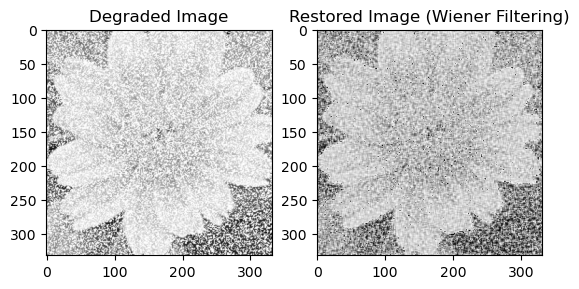

In [11]:
# 读取退化图像（以灰度图模式读取，）
image_degraded = cv2.imread('degraded-flower.jpg', 0)

# 假设已知退化函数（这里简单模拟一个退化函数示例，实际应用中需根据具体退化情况确定）
h = np.ones((5, 5)) / 25
# 假设噪声和原始图像功率谱密度（这里简单模拟示例值，实际需准确估计或已知）
sn = np.ones_like(image_degraded) * 10
sf = np.ones_like(image_degraded) * 100

# 进行维纳滤波
restored_image = wiener_filtering(image_degraded, h, sn, sf)

# 使用matplotlib在Jupyter Notebook中显示退化图像和恢复后的图像
plt.subplot(1, 2, 1)
plt.imshow(image_degraded, cmap='gray')
plt.title('Degraded Image')

plt.subplot(1, 2, 2)
plt.imshow(restored_image, cmap='gray')
plt.title('Restored Image (Wiener Filtering)')

plt.show()